In [2]:
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import math
import timeit
import seaborn as sns

In [3]:
theta = np.loadtxt("C:/Users/User/Desktop/emanuele/installed/MG5_aMC_v3_3_1/gg_hh_energia_variabile/SubProcesses/P0_gg_hh/Angles_final.txt", delimiter=" ", unpack='true')

E = np.loadtxt("C:/Users/User/Desktop/emanuele/installed/MG5_aMC_v3_3_1/gg_hh_energia_variabile/SubProcesses/P0_gg_hh/Energy_final.txt", delimiter=" ", unpack='true')

M = np.loadtxt("C:/Users/User/Desktop/emanuele/installed/MG5_aMC_v3_3_1/gg_hh_energia_variabile/SubProcesses/P0_gg_hh/MatrElem_final.txt", delimiter=" ", unpack='true')

t = np.loadtxt("C:/Users/User/Desktop/emanuele/installed/MG5_aMC_v3_3_1/gg_hh_energia_variabile/SubProcesses/P0_gg_hh/Time_final.txt", delimiter=" ", unpack='true')


In [4]:
xy = np.matrix([theta,E])
xy = xy.T
xy = xy.A
xy = xy.reshape(len(E),2)
print(xy.shape,type(xy))

(9999776, 2) <class 'numpy.ndarray'>


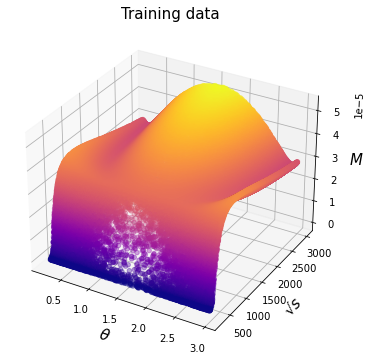

In [5]:
fig = plt.figure(figsize=(6,6))
#ax = Axes3D(fig)
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Training data", fontsize=15)
ax.scatter(xy[3000000:3100000,0], xy[3000000:3100000,1], M[3000000:3100000], label='Training', alpha=0.35, c=M[3000000:3100000], cmap='plasma')
ax.set_xlabel('$ \u03B8 $', fontsize=15)
ax.set_ylabel('$ \u221A s$', fontsize=15)
ax.set_zlabel('$M$', fontsize=15)
#plt.ylim(1000)
#ax.view_init(45,35)
plt.savefig('C:/Users/User/Desktop/gghhrealdata.png')
plt.show()

# Reti Neurali
## Preparazione

In [5]:
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import optimizers, losses, metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras import activations
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from numpy import mean
from numpy import std

In [7]:
def baseline_model_dataset(layers, lr=0.001, activation='relu', loss='mean_squared_error'):
        'define and compile model with fixing weight initialisers and a random dataset'
        # create model
        # at some point can use new Keras tuning feature for optimising this model

        
        model = Sequential()
        model.add(Dense(10, input_shape=(2,),activation='relu'))
        model.add(Dense(layers[0], input_dim=(2))) #dim può essere anche "2", non lo so
        if activation == 'tanh':
            model.add(Activation(activations.tanh))
        elif activation == 'relu':
            model.add(Activation(activations.relu))
        else:
            raise ValueError('activation supported are either tanh or relu, you have used {}'.format(activation))

        for i in range(1,len(layers)):
            model.add(Dense(layers[i]))
            if activation == 'tanh':
                model.add(Activation(activations.tanh))
            elif activation == 'relu':
                model.add(Activation(activations.relu))

        model.add(Dense(1))
        # Compile model
        model.compile(optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False), loss = loss)
        
        return model



In [8]:
def baseline_model(layers, lr=0.001, activation='tanh', loss='mean_squared_error'):
        'define and compile model with a fixed dataset but random weights'
        # create model
        # at some point can use new Keras tuning feature for optimising this model
        model = Sequential()
        model.add(Dense(layers[0], input_dim=(2)))
        if activation == 'tanh':
            model.add(Activation(activations.tanh))
        elif activation == 'relu':
            model.add(Activation(activations.relu))
        else:
            raise ValueError('activation supported are either tanh or relu, you have used {}'.format(activation))
        
        for i in range(1, len(layers)):
            model.add(Dense(layers[i]))
            if activation == 'tanh':
                model.add(Activation(activations.tanh))
            elif activation == 'relu':
                model.add(Activation(activations.relu))

        model.add(Dense(1))
        # Compile model
        model.compile(optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False), loss = loss)
        
        return model

In [9]:
def get_dataset(xy, M, input_scaler, output_scaler, interval):
	# generate dataset
	#X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)
	# split into train and test
	#n_train = 500
    n_train = int(interval / 100 * 70)
    n_valid = int(interval / 100 * 30)
    print ("# training points :",n_train,"\n# validation points: ", n_valid)
    trainX, testX = xy[:n_train], xy[n_train:n_train + n_valid]
    trainy, testy = M[:n_train], M[n_train:n_train + n_valid]
	# scale inputs
    if input_scaler is not None:
        # fit scaler
        input_scaler.fit(trainX)
        # transform training dataset
        trainX = input_scaler.transform(trainX)
        # transform test dataset
        testX = input_scaler.transform(testX)
    if output_scaler is not None:
        # reshape 1d arrays to 2d arrays
        trainy = trainy.reshape(len(trainy), 1)
        testy = testy.reshape(len(testy), 1)
        # fit scaler on training dataset
        output_scaler.fit(trainy)
        # transform training dataset
        trainy = output_scaler.transform(trainy)
        # transform test dataset
        testy = output_scaler.transform(testy)
    return trainX, trainy, testX, testy, output_scaler, input_scaler

In [10]:
def prediction_NN(begin ,dim, xy, M, scaler_output, scaler_input):
    xy_valid = xy[begin:begin+dim]
    scaler_input.fit(xy_valid)
    #transform training dataset
    xy_valid = scaler_input.transform(xy_valid)
    #transform test dataset

    z_valid = M[begin:begin+dim]
    z_valid = z_valid.reshape(len(z_valid), 1)
    #fit scaler on training dataset
    scaler_output.fit(z_valid)
    # transform training dataset
    z_valid = scaler_output.transform(z_valid)
    # transform test dataset
    
    return xy_valid, z_valid



In [11]:
def rescale(xy_valid, z_predicted, z_valid, scaler_input, scaler_output):
    xy_valid = scaler_input.inverse_transform(xy_valid)
    z_predicted = scaler_output.inverse_transform(z_predicted)
    z_predicted = z_predicted.reshape(len(z_predicted),)
    z_valid = scaler_output.inverse_transform(z_valid)
    z_valid = z_valid.reshape(len(z_valid),)
    return xy_valid, z_predicted, z_valid

In [12]:
def relative_error(z_predicted, z_valid):
    err = abs(np.diff([z_predicted,z_valid],axis=0))
    err = err.reshape(len(z_predicted),)
    err = np.divide(err,z_valid)
    return err

In [13]:
def array_for_error_map (val_ang, val_en, cut_value, xy_valid, err, gg, dim):
    err_map = np.zeros((dim, dim))
    err_counter = np.zeros((dim,dim))

    if gg == 'ang':
        for i in range(len(xy_valid)):
            for j in range(dim):
                for k in range(dim):
                    if xy_valid[i,0] > cut_value + val_ang*(k) and xy_valid[i,0] < cut_value + val_ang*(k+1) and xy_valid[i,1] > 250.7 + val_en*j and xy_valid[i,1] < 250.7 + val_en*(j+1):
                        err_map[j,k] += err[i]
                        #print(err_map[k,j])
                        err_counter[k,j] += 1
    elif gg == 'en':
        for i in range(len(xy_valid)):
            for j in range(dim):
                for k in range(dim):
                    if xy_valid[i,0] > val_ang*(k) and xy_valid[i,0] < val_ang*(k+1) and xy_valid[i,1] > cut_value + val_en*j and xy_valid[i,1] < cut_value + val_en*(j+1):
                        err_map[k,j] += err[i]
                        #print(err_map[k,j])
                        err_counter[k,j] += 1
    else:
        raise ValueError('You can pick ang or en, you have used {}'.format(gg))
        
        
                    
    for j in range(dim):
        for k in range(dim):
            err_map[k,j] /= err_counter[k,j]
            
    return err_map


# Rete Neurale #1

In [23]:
xy_train, z_train, xy_valid, z_valid, scaler_out, scaler_in = get_dataset(xy, M, StandardScaler(), StandardScaler(),5000000)



# training points : 3500000 
# validation points:  1500000


### Modello

In [24]:
layers1 = [20,40,20]
model1 = baseline_model(layers1, lr=0.001, activation='tanh', loss='mse')
# compile the model choosing optimizer, loss and metrics objects
#model7.compile(optimizer='adam', loss='mse', metrics=['mse'])

#model1.compile(optimizer = Adadelta(learning_rate = 1.0), loss = 'mse')

ES = EarlyStopping(monitor='val_loss', min_delta=0, patience=100,
                   verbose=0, restore_best_weights=True)

In [25]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                60        
_________________________________________________________________
activation (Activation)      (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                840       
_________________________________________________________________
activation_1 (Activation)    (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
activation_2 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2

### Fit e prestazioni

In [26]:
start = timeit.default_timer()

history = model1.fit(x=xy_train, y=z_train, 
          batch_size=512, epochs=10000,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(xy_valid, z_valid),
          callbacks=[ES])

stop = timeit.default_timer()
training_time1 = stop - start
print('Time: ', training_time1)

Epoch 1/10000
6836/6836 [==============================] - 10s 1ms/step - loss: 0.0500 - val_loss: 8.8995e-04
Epoch 2/10000
6836/6836 [==============================] - 9s 1ms/step - loss: 3.2932e-04 - val_loss: 1.2656e-04
Epoch 3/10000
6836/6836 [==============================] - 9s 1ms/step - loss: 1.1606e-04 - val_loss: 1.9495e-04
Epoch 4/10000
6836/6836 [==============================] - 11s 2ms/step - loss: 8.3185e-05 - val_loss: 3.3273e-05
Epoch 5/10000
6836/6836 [==============================] - 13s 2ms/step - loss: 7.1933e-05 - val_loss: 5.6009e-05
Epoch 6/10000
6836/6836 [==============================] - 12s 2ms/step - loss: 6.6081e-05 - val_loss: 3.5645e-05
Epoch 7/10000
6836/6836 [==============================] - 12s 2ms/step - loss: 6.2122e-05 - val_loss: 2.3418e-05
Epoch 8/10000
6836/6836 [==============================] - 11s 2ms/step - loss: 6.0045e-05 - val_loss: 3.2375e-05
Epoch 9/10000
6836/6836 [==============================] - 9s 1ms/step - loss: 5.7398e-05 - va

46875/46875 [==============================] - 45s 945us/step - loss: 4.2038e-07

Test loss: 4.203836567739927e-07


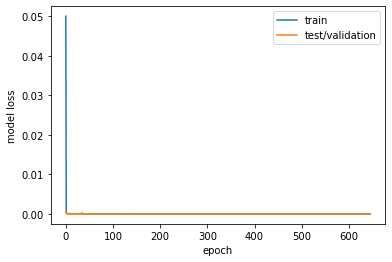

In [27]:
score = model1.evaluate(xy_valid, z_valid, batch_size=32, verbose=1)

# print performance
print()
print('Test loss:', score)
#print('Test accuracy:', score[1])

# look into training history

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test/validation'], loc='best')
plt.show()

Prediction time:  14.014958053000555


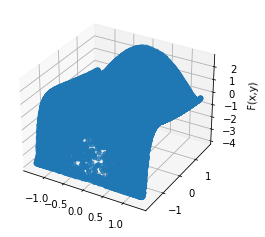

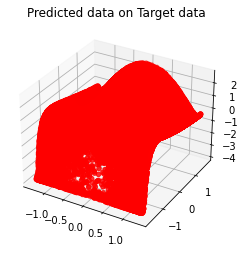

In [28]:
xy_valid, z_valid = prediction_NN(5000000,1000000, xy, M, scaler_out ,scaler_in)

start = timeit.default_timer()
z_predicted = model1.predict(xy_valid)
stop = timeit.default_timer()
prediction_time1 = stop - start

init = 0
end = 50000
print ("Prediction time: ", prediction_time1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel('F(x,y)')
ax.scatter(xy_valid[init:end,0],xy_valid[init:end,1], z_valid[init:end])
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_title("Predicted data on Target data")
ax1.scatter(xy_valid[init:end,0], xy_valid[init:end,1], z_predicted[init:end],c='red')
plt.grid(True); plt.show()


### Annullamento scaling

In [29]:
xy_valid, z_predicted, z_valid = rescale(xy_valid, z_predicted, z_valid, scaler_in, scaler_out)


In [30]:
err_1 = relative_error(z_predicted, z_valid)

### Errori

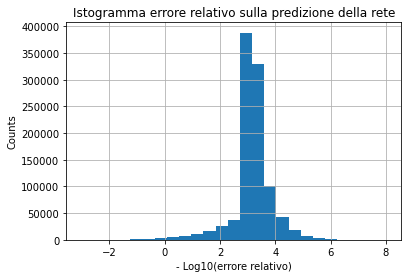

In [53]:
n_bins = 25
n, bins, patches = plt.hist(-np.log10(err_1), n_bins, range=(-3,8))

plt.xlabel('- Log10(errore relativo)')
plt.ylabel("Counts")
plt.title('Istogramma errore relativo sulla predizione della rete')
plt.grid(True)
plt.show()

### Mappa degli errori

In [37]:
val_ang = (math.pi)/10
val_en = (3000 - 125.35*2)/10

In [41]:
err_map_1 = array_for_error_map (val_ang, val_en, 0, xy_valid, err_1, 'ang', 10)


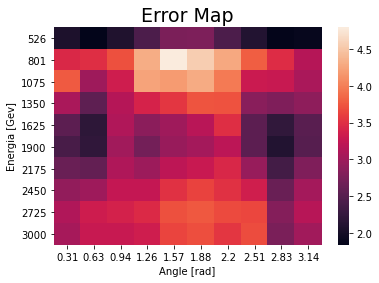

In [42]:
ang1 = []
En1 = []
for i in range(10):
    ang1.append(round((i+1)*val_ang,2))
    En1.append(round(125.35*2+(i+1)*val_en,))
    
ax = sns.heatmap(-np.log10(err_map_1),xticklabels = ang1, yticklabels = En1)
ax.set_title("Error Map", fontsize = 19)
ax.set_ylabel("Energia [Gev]")
ax.set_xlabel("Angle [rad]")
plt.show()

In [45]:
t1 = 0
for i in range(len(t)):
    t1 += t[i]
    
print ("Tempo per la generazione di", len(M),"elementi con MadGraph:",t1)
print ("Tempo di training della rete:", training_time1)
print ("Tempo di predizione della rete di",len(z_predicted),"elementi:", prediction_time1)

Tempo per la generazione di 9999776 elementi con MadGraph: 29845.920000000002
Tempo di training della rete: 6058.198388412
Tempo di predizione della rete di 1000000 elementi: 14.014958053000555


In [47]:
t_1 = t1/len(M)
t_regression1 = t_1*len(z_predicted)
print("Interpolazione del tempo di generazione di",len(z_predicted),"elementi con MadGraph:",t_regression1)

Interpolazione del tempo di generazione di 1000000 elementi con MadGraph: 2984.6588563583823


In [48]:
n_min1 = round(training_time1/(t1/len(M)-prediction_time1/len(z_predicted)))

In [49]:
print("Numero minimo necessario per riassorbire il tempo di predizione della rete e renderlo un metodo conveniente:",n_min1)


Numero minimo necessario per riassorbire il tempo di predizione della rete e renderlo un metodo conveniente: 2039355


# Rete Neurale #2

In [14]:
xy_train, z_train, xy_valid, z_valid, scaler_out, scaler_in = get_dataset(xy, M, MinMaxScaler(), MinMaxScaler(),5000000)



# training points : 3500000 
# validation points:  1500000


### Modello

In [15]:
layers2 = [20,40,20]
model2 = baseline_model(layers2, lr=0.001, activation='tanh', loss='mse')
# compile the model choosing optimizer, loss and metrics objects
#model7.compile(optimizer='adam', loss='mse', metrics=['mse'])

#model1.compile(optimizer = Adadelta(learning_rate = 1.0), loss = 'mse')

ES = EarlyStopping(monitor='val_loss', min_delta=0, patience=100,
                   verbose=0, restore_best_weights=True)

In [16]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                60        
_________________________________________________________________
activation (Activation)      (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                840       
_________________________________________________________________
activation_1 (Activation)    (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
activation_2 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2

### Fit e prestazioni

In [17]:
start = timeit.default_timer()

history = model2.fit(x=xy_train, y=z_train, 
          batch_size=512, epochs=10000,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(xy_valid, z_valid),
          callbacks=[ES])

stop = timeit.default_timer()
training_time2 = stop - start
print('Time: ', training_time2)

Epoch 1/10000
6836/6836 [==============================] - 20s 3ms/step - loss: 0.0026 - val_loss: 2.2143e-04
Epoch 2/10000
6836/6836 [==============================] - 18s 3ms/step - loss: 1.0500e-04 - val_loss: 2.6908e-05
Epoch 3/10000
6836/6836 [==============================] - 18s 3ms/step - loss: 2.1234e-05 - val_loss: 1.0657e-05
Epoch 4/10000
6836/6836 [==============================] - 21s 3ms/step - loss: 1.0966e-05 - val_loss: 7.1563e-06
Epoch 5/10000
6836/6836 [==============================] - 23s 3ms/step - loss: 7.7016e-06 - val_loss: 4.8328e-06
Epoch 6/10000
6836/6836 [==============================] - 22s 3ms/step - loss: 6.3701e-06 - val_loss: 6.4323e-06
Epoch 7/10000
6836/6836 [==============================] - 21s 3ms/step - loss: 5.3605e-06 - val_loss: 3.3557e-06
Epoch 8/10000
6836/6836 [==============================] - 22s 3ms/step - loss: 4.6005e-06 - val_loss: 1.7497e-06oss: 4.60 - ETA: 0s - loss: 4.6012e-0
Epoch 9/10000
6836/6836 [==============================

6836/6836 [==============================] - 22s 3ms/step - loss: 7.5635e-07 - val_loss: 7.6356e-07
Epoch 72/10000
6836/6836 [==============================] - 19s 3ms/step - loss: 7.5634e-07 - val_loss: 4.0573e-07
Epoch 73/10000
6836/6836 [==============================] - 26s 4ms/step - loss: 7.2671e-07 - val_loss: 4.7865e-07
Epoch 74/10000
6836/6836 [==============================] - 23s 3ms/step - loss: 7.1814e-07 - val_loss: 4.6019e-07
Epoch 75/10000
6836/6836 [==============================] - 24s 4ms/step - loss: 7.0639e-07 - val_loss: 3.1700e-07
Epoch 76/10000
6836/6836 [==============================] - 19s 3ms/step - loss: 6.8643e-07 - val_loss: 3.8763e-076. - ETA: 0s - lo
Epoch 77/10000
6836/6836 [==============================] - 20s 3ms/step - loss: 6.8254e-07 - val_loss: 7.2792e-07
Epoch 78/10000
6836/6836 [==============================] - 19s 3ms/step - loss: 6.6703e-07 - val_loss: 2.6010e-07
Epoch 79/10000
6836/6836 [==============================] - 20s 3ms/step - los

6836/6836 [==============================] - 20s 3ms/step - loss: 2.8581e-07 - val_loss: 7.9151e-07
Epoch 211/10000
6836/6836 [==============================] - 20s 3ms/step - loss: 2.8324e-07 - val_loss: 1.4218e-07
Epoch 212/10000
6836/6836 [==============================] - 20s 3ms/step - loss: 2.7896e-07 - val_loss: 3.8086e-07
Epoch 213/10000
6836/6836 [==============================] - 20s 3ms/step - loss: 2.8192e-07 - val_loss: 9.2287e-08
Epoch 214/10000
6836/6836 [==============================] - 20s 3ms/step - loss: 2.8228e-07 - val_loss: 4.3182e-08
Epoch 215/10000
6836/6836 [==============================] - 20s 3ms/step - loss: 2.8319e-07 - val_loss: 6.6844e-07
Epoch 216/10000
6836/6836 [==============================] - 21s 3ms/step - loss: 2.7899e-07 - val_loss: 1.8949e-07
Epoch 217/10000
6836/6836 [==============================] - 20s 3ms/step - loss: 2.7984e-07 - val_loss: 2.8596e-07oss: 2.7
Epoch 218/10000
6836/6836 [==============================] - 20s 3ms/step - loss

6836/6836 [==============================] - 15s 2ms/step - loss: 2.2457e-07 - val_loss: 1.6664e-07
Epoch 350/10000
6836/6836 [==============================] - 16s 2ms/step - loss: 2.2771e-07 - val_loss: 5.9408e-08
Epoch 351/10000
6836/6836 [==============================] - 15s 2ms/step - loss: 2.2418e-07 - val_loss: 1.0324e-06
Epoch 352/10000
6836/6836 [==============================] - 15s 2ms/step - loss: 2.2721e-07 - val_loss: 1.4331e-07
Epoch 353/10000
6836/6836 [==============================] - 15s 2ms/step - loss: 2.1874e-07 - val_loss: 1.3512e-07
Epoch 354/10000
6836/6836 [==============================] - 15s 2ms/step - loss: 2.2079e-07 - val_loss: 5.8455e-07
Epoch 355/10000
6836/6836 [==============================] - 15s 2ms/step - loss: 2.2266e-07 - val_loss: 4.8937e-07
Epoch 356/10000
6836/6836 [==============================] - 15s 2ms/step - loss: 2.2268e-07 - val_loss: 8.4648e-08
Epoch 357/10000
6836/6836 [==============================] - 15s 2ms/step - loss: 2.2621

46875/46875 [==============================] - 59s 1ms/step - loss: 2.8551e-08

Test loss: 2.8551122355224834e-08


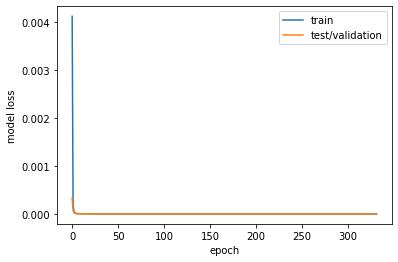

In [19]:
score = model2.evaluate(xy_valid, z_valid, batch_size=32, verbose=1)

# print performance
print()
print('Test loss:', score)
#print('Test accuracy:', score[1])

# look into training history

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test/validation'], loc='best')
plt.show()

Prediction time:  29.854417899998225


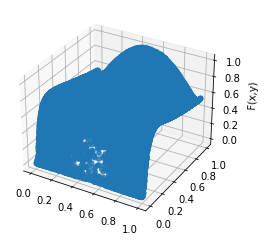

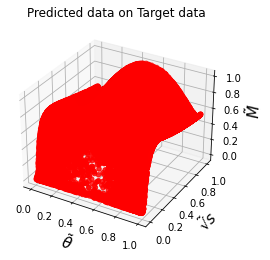

In [20]:
xy_valid, z_valid = prediction_NN(5000000,1000000, xy, M, scaler_out ,scaler_in)

start = timeit.default_timer()
z_predicted = model2.predict(xy_valid)
stop = timeit.default_timer()
prediction_time2 = stop - start

init = 0
end = 50000
print ("Prediction time: ", prediction_time2)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel('F(x,y)')
ax.scatter(xy_valid[init:end,0],xy_valid[init:end,1], z_valid[init:end])
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_title("Predicted data on Target data")
ax1.scatter(xy_valid[init:end,0], xy_valid[init:end,1], z_predicted[init:end],c='red')
ax1.set_xlabel('$\~ \u03B8 $', fontsize=15)
ax1.set_ylabel('$\~ \u221A s$', fontsize=15)
ax1.set_zlabel('$\~ M$', fontsize=15)
#plt.ylim(1000)
#ax.view_init(45,35)
plt.savefig('C:/Users/User/Desktop/gghhpredictedfirst.png')
plt.grid(True); plt.show()


### Annullamento scaling

In [21]:
xy_valid, z_predicted, z_valid = rescale(xy_valid, z_predicted, z_valid, scaler_in, scaler_out)


In [22]:
err_2 = relative_error(z_predicted, z_valid)

### Errori

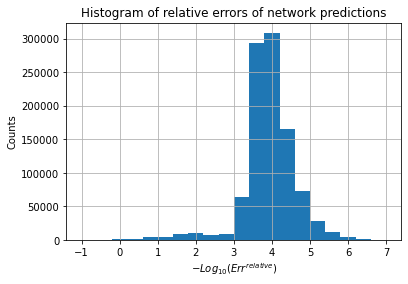

In [26]:
n_bins = 20
n, bins, patches = plt.hist(-np.log10(err_2), n_bins, range=(-1,7))

plt.xlabel('$- Log_{10}(Err^{relative})$')
plt.ylabel("Counts")
plt.title('Histogram of relative errors of network predictions')
plt.grid(True)
plt.savefig('C:/Users/User/Desktop/gghhhistofirst.png')
plt.show()

### Mappa degli errori

In [27]:
val_ang = (math.pi)/10
val_en = (3000 - 125.35*2)/10

In [28]:
err_map_2 = array_for_error_map (val_ang, val_en, 0, xy_valid, err_2, 'ang', 10)


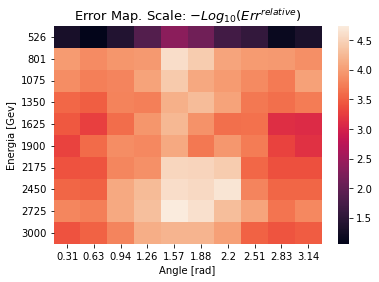

In [30]:
ang2 = []
En2 = []
for i in range(10):
    ang2.append(round((i+1)*val_ang,2))
    En2.append(round(125.35*2+(i+1)*val_en,))
    
ax = sns.heatmap(-np.log10(err_map_2),xticklabels = ang2, yticklabels = En2)
ax.set_title("Error Map. Scale: $- Log_{10}(Err^{relative})$", fontsize = 13)
ax.set_ylabel("Energia [Gev]")
ax.set_xlabel("Angle [rad]")
plt.savefig('C:/Users/User/Desktop/gghhmapfirst.png')
plt.show()

In [31]:
t_sum = 0
for i in range(len(t)):
    t_sum += t[i]
    
print ("Tempo per la generazione di", len(M),"elementi con MadGraph:",t_sum)
print ("Tempo di training della rete:", training_time2)
print ("Tempo di predizione della rete di",len(z_predicted),"elementi:", prediction_time2)

Tempo per la generazione di 9999776 elementi con MadGraph: 29845.920000000002
Tempo di training della rete: 3490.9496185000003
Tempo di predizione della rete di 1000000 elementi: 13.914960747999885


In [28]:
t_1 = t/len(M)
t_regression1 = t_1*len(z_predicted)
print("Interpolazione del tempo di generazione di",len(z_predicted),"elementi con MadGraph:",t_regression1)

Interpolazione del tempo di generazione di 99974 elementi con MadGraph: 957.0152886824628


In [32]:
n_min2 = round(training_time2/(t_sum/len(M)-prediction_time2/len(z_predicted)))

In [33]:
print("Numero minimo necessario per riassorbire il tempo di predizione della rete e renderlo un metodo conveniente:",n_min2)


Numero minimo necessario per riassorbire il tempo di predizione della rete e renderlo un metodo conveniente: 1175110


# Rete Neurale #3

In [31]:
xy_train, z_train, xy_valid, z_valid, scaler_out, scaler_in = get_dataset(xy, M, MinMaxScaler(), MinMaxScaler(),5000000)



# training points : 3500000 
# validation points:  1500000


### Modello

In [32]:
#layers3 = [20,40,20]
#model3 = baseline_model(layers3, lr=0.001, activation='relu', loss='mse')
# compile the model choosing optimizer, loss and metrics objects
#model7.compile(optimizer='adam', loss='mse', metrics=['mse'])

#model1.compile(optimizer = Adadelta(learning_rate = 1.0), loss = 'mse')

ES = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, 
                   verbose=0, restore_best_weights=True)

model3 = tf.keras.Sequential()
model3.add(Dense(15, input_shape=(2,),activation='relu'))
model3.add(Dense(40, input_shape=(2,),activation='tanh'))
model3.add(Dense(45, input_shape=(2,),activation='relu'))
model3.add(Dense(30, input_shape=(2,),activation='tanh'))
model3.add(Dense(15, input_shape=(2,),activation='relu'))
model3.add(Dense(1))
model3.compile(optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss = 'mse')



In [33]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 15)                45        
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 45)                1845      
_________________________________________________________________
dense_7 (Dense)              (None, 30)                1380      
_________________________________________________________________
dense_8 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 16        
Total params: 4,391
Trainable params: 4,391
Non-trainable params: 0
____________________________________________________

### Fit e prestazioni

In [34]:
start = timeit.default_timer()

history = model3.fit(x=xy_train, y=z_train, 
          batch_size = 256, epochs=100,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(xy_valid, z_valid))

stop = timeit.default_timer()
training_time3 = stop - start
print('Time: ', training_time3)

Epoch 1/100
13672/13672 [==============================] - 46s 3ms/step - loss: 5.0524e-04 - val_loss: 2.7230e-05
Epoch 2/100
13672/13672 [==============================] - 45s 3ms/step - loss: 2.7315e-05 - val_loss: 1.8803e-05
Epoch 3/100
13672/13672 [==============================] - 40s 3ms/step - loss: 2.0530e-05 - val_loss: 1.4317e-05
Epoch 4/100
13672/13672 [==============================] - 40s 3ms/step - loss: 1.7239e-05 - val_loss: 1.3942e-05
Epoch 5/100
13672/13672 [==============================] - 39s 3ms/step - loss: 1.4776e-05 - val_loss: 6.3077e-06
Epoch 6/100
13672/13672 [==============================] - 41s 3ms/step - loss: 1.1762e-05 - val_loss: 6.6557e-06
Epoch 7/100
13672/13672 [==============================] - 40s 3ms/step - loss: 1.0110e-05 - val_loss: 1.0536e-05
Epoch 8/100
13672/13672 [==============================] - 43s 3ms/step - loss: 8.6802e-06 - val_loss: 3.7121e-06
Epoch 9/100
13672/13672 [==============================] - 42s 3ms/step - loss: 7.6916e-

46875/46875 [==============================] - 95s 2ms/step - loss: 1.0384e-06

Test loss: 1.0383798780821962e-06


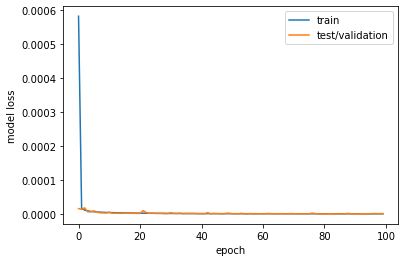

In [22]:
score = model3.evaluate(xy_valid, z_valid, batch_size=32, verbose=1)

# print performance
print()
print('Test loss:', score)
#print('Test accuracy:', score[1])

# look into training history

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test/validation'], loc='best')
plt.show()

Prediction time:  30.64558080000006


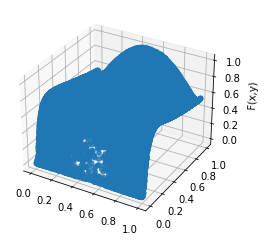

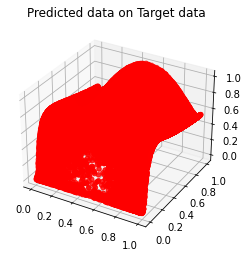

In [23]:
xy_valid, z_valid = prediction_NN(5000000,1000000, xy, M, scaler_out ,scaler_in)

start = timeit.default_timer()
z_predicted = model3.predict(xy_valid)
stop = timeit.default_timer()
prediction_time3 = stop - start

init = 0
end = 50000
print ("Prediction time: ", prediction_time3)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel('F(x,y)')
ax.scatter(xy_valid[init:end,0],xy_valid[init:end,1], z_valid[init:end])
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_title("Predicted data on Target data")
ax1.scatter(xy_valid[init:end,0], xy_valid[init:end,1], z_predicted[init:end],c='red')
plt.grid(True); plt.show()


### Annullamento scaling

In [24]:
xy_valid, z_predicted, z_valid = rescale(xy_valid, z_predicted, z_valid, scaler_in, scaler_out)


In [25]:
err_3 = relative_error(z_predicted, z_valid)

### Errori

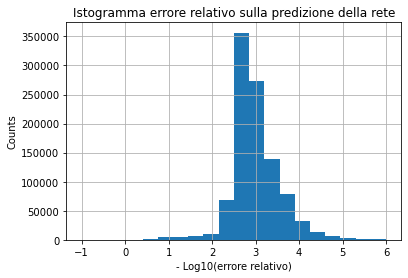

In [26]:
n_bins = 20
n, bins, patches = plt.hist(-np.log10(err_3), n_bins, range=(-1,6))

plt.xlabel('- Log10(errore relativo)')
plt.ylabel("Counts")
plt.title('Istogramma errore relativo sulla predizione della rete')
plt.grid(True)
plt.show()

### Mappa degli errori

In [27]:
val_ang = (math.pi)/10
val_en = (3000 - 125.35*2)/10

In [28]:
err_map_3 = array_for_error_map (val_ang, val_en, 0, xy_valid, err_3, 'ang', 10)


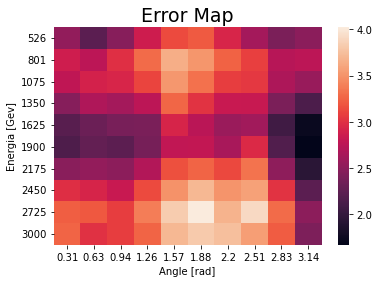

In [29]:
ang3 = []
En3 = []
for i in range(10):
    ang3.append(round((i+1)*val_ang,2))
    En3.append(round(125.35*2+(i+1)*val_en,))
    
ax = sns.heatmap(-np.log10(err_map_3),xticklabels = ang3, yticklabels = En3)
ax.set_title("Error Map", fontsize = 19)
ax.set_ylabel("Energia [Gev]")
ax.set_xlabel("Angle [rad]")
plt.show()

In [32]:
t_sum = 0
for i in range(len(t)):
    t_sum += t[i]
    
print ("Tempo per la generazione di", len(M),"elementi con MadGraph:",t_sum)
print ("Tempo di training della rete:", training_time3)
print ("Tempo di predizione della rete di",len(z_predicted),"elementi:", prediction_time3)


Tempo per la generazione di 9999776 elementi con MadGraph: 29845.920000000002
Tempo di training della rete: 3469.5230407
Tempo di predizione della rete di 1000000 elementi: 30.64558080000006


In [34]:
t_1 = t_sum/len(M)
t_regression1 = t_1*len(z_predicted)
print("Interpolazione del tempo di generazione di",len(z_predicted),"elementi con MadGraph:",t_regression1)

Interpolazione del tempo di generazione di 1000000 elementi con MadGraph: 2984.6588563583823


In [35]:
n_min3 = round(training_time3/(t_sum/len(M)-prediction_time3/len(z_predicted)))

In [36]:
print("Numero minimo necessario per riassorbire il tempo di predizione della rete e renderlo un metodo conveniente:",n_min3)


Numero minimo necessario per riassorbire il tempo di predizione della rete e renderlo un metodo conveniente: 1174512


# Rete Neurale #4

In [39]:
xy_train, z_train, xy_valid, z_valid, scaler_out, scaler_in = get_dataset(xy, M, MinMaxScaler(), MinMaxScaler(),5000000)



# training points : 3500000 
# validation points:  1500000


### Modello

In [40]:
#layers3 = [20,40,20]
#model3 = baseline_model(layers3, lr=0.001, activation='relu', loss='mse')
# compile the model choosing optimizer, loss and metrics objects
#model7.compile(optimizer='adam', loss='mse', metrics=['mse'])

#model1.compile(optimizer = Adadelta(learning_rate = 1.0), loss = 'mse')

ES = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, 
                   verbose=0, restore_best_weights=True)

model4 = tf.keras.Sequential()
model4.add(Dense(15, input_shape=(2,),activation='relu'))
model4.add(Dense(40, input_shape=(2,),activation='tanh'))
model4.add(Dense(45, input_shape=(2,),activation='relu'))
model4.add(Dense(30, input_shape=(2,),activation='tanh'))
model4.add(Dense(15, input_shape=(2,),activation='relu'))
model4.add(Dense(1))
model4.compile(optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss = 'mse')



In [41]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 15)                45        
_________________________________________________________________
dense_17 (Dense)             (None, 40)                640       
_________________________________________________________________
dense_18 (Dense)             (None, 45)                1845      
_________________________________________________________________
dense_19 (Dense)             (None, 30)                1380      
_________________________________________________________________
dense_20 (Dense)             (None, 15)                465       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 16        
Total params: 4,391
Trainable params: 4,391
Non-trainable params: 0
____________________________________________________

### Fit e prestazioni

In [42]:
start = timeit.default_timer()

history = model4.fit(x=xy_train, y=z_train, 
          batch_size = 512, epochs=1000,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(xy_valid, z_valid),
                     callbacks=[ES])

stop = timeit.default_timer()
training_time4 = stop - start
print('Time: ', training_time4)

Epoch 1/1000
6836/6836 [==============================] - 25s 3ms/step - loss: 8.9837e-04 - val_loss: 1.6547e-05
Epoch 2/1000
6836/6836 [==============================] - 20s 3ms/step - loss: 2.0474e-05 - val_loss: 3.6519e-05
Epoch 3/1000
6836/6836 [==============================] - 19s 3ms/step - loss: 1.5242e-05 - val_loss: 1.3994e-05
Epoch 4/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 1.2474e-05 - val_loss: 1.2067e-05
Epoch 5/1000
6836/6836 [==============================] - 17s 3ms/step - loss: 1.0186e-05 - val_loss: 6.3135e-06
Epoch 6/1000
6836/6836 [==============================] - 19s 3ms/step - loss: 8.5177e-06 - val_loss: 4.8828e-06
Epoch 7/1000
6836/6836 [==============================] - 18s 3ms/step - loss: 7.6096e-06 - val_loss: 5.6988e-06
Epoch 8/1000
6836/6836 [==============================] - 18s 3ms/step - loss: 6.7834e-06 - val_loss: 5.2751e-06
Epoch 9/1000
6836/6836 [==============================] - 19s 3ms/step - loss: 6.1204e-06 - val_

6836/6836 [==============================] - 21s 3ms/step - loss: 4.4567e-07 - val_loss: 2.0877e-07
Epoch 144/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 4.6107e-07 - val_loss: 2.0013e-07
Epoch 145/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 4.4433e-07 - val_loss: 1.7940e-07
Epoch 146/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 4.6887e-07 - val_loss: 6.1951e-07
Epoch 147/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 4.4719e-07 - val_loss: 1.5050e-07
Epoch 148/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 4.3105e-07 - val_loss: 3.2097e-07
Epoch 149/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 4.3778e-07 - val_loss: 3.7066e-07
Epoch 150/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 4.4111e-07 - val_loss: 3.3311e-07
Epoch 151/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 4.3685e-07 - v

6836/6836 [==============================] - 21s 3ms/step - loss: 2.7033e-07 - val_loss: 5.2656e-07
Epoch 286/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 2.6246e-07 - val_loss: 1.3902e-07
Epoch 287/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 2.8750e-07 - val_loss: 2.8203e-07
Epoch 288/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 2.7388e-07 - val_loss: 7.6136e-07
Epoch 289/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 2.5679e-07 - val_loss: 1.0695e-07
Epoch 290/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 2.6085e-07 - val_loss: 6.1166e-08
Epoch 291/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 2.6458e-07 - val_loss: 8.7303e-08
Epoch 292/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 2.7335e-07 - val_loss: 1.0150e-07
Epoch 293/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 2.7135e-07 - v

6836/6836 [==============================] - 21s 3ms/step - loss: 2.1887e-07 - val_loss: 1.5540e-07
Epoch 428/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 2.2551e-07 - val_loss: 1.2580e-07
Epoch 429/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 2.1202e-07 - val_loss: 3.4704e-07
Epoch 430/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 2.1856e-07 - val_loss: 4.6343e-08
Epoch 431/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 2.1748e-07 - val_loss: 4.3745e-08
Epoch 432/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 2.1670e-07 - val_loss: 6.4921e-08
Epoch 433/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 2.1391e-07 - val_loss: 1.1691e-07
Epoch 434/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 2.1684e-07 - val_loss: 1.2538e-07
Epoch 435/1000
6836/6836 [==============================] - 21s 3ms/step - loss: 2.1744e-07 - v

6836/6836 [==============================] - 17s 2ms/step - loss: 1.7223e-07 - val_loss: 1.0888e-07
Epoch 570/1000
6836/6836 [==============================] - 17s 2ms/step - loss: 1.8882e-07 - val_loss: 1.4982e-07
Epoch 571/1000
6836/6836 [==============================] - 17s 2ms/step - loss: 1.7832e-07 - val_loss: 1.0462e-07
Epoch 572/1000
6836/6836 [==============================] - 17s 2ms/step - loss: 1.7755e-07 - val_loss: 2.4760e-07
Epoch 573/1000
6836/6836 [==============================] - 17s 2ms/step - loss: 1.8021e-07 - val_loss: 5.1036e-08
Epoch 574/1000
6836/6836 [==============================] - 17s 2ms/step - loss: 1.8694e-07 - val_loss: 2.5297e-07
Epoch 575/1000
6836/6836 [==============================] - 17s 2ms/step - loss: 1.7580e-07 - val_loss: 4.7768e-08
Epoch 576/1000
6836/6836 [==============================] - 17s 2ms/step - loss: 1.7525e-07 - val_loss: 3.7218e-07
Epoch 577/1000
6836/6836 [==============================] - 17s 3ms/step - loss: 1.7628e-07 - v

6836/6836 [==============================] - 17s 2ms/step - loss: 1.4409e-07 - val_loss: 5.4477e-08
Epoch 712/1000
6836/6836 [==============================] - 17s 2ms/step - loss: 1.4868e-07 - val_loss: 1.7980e-07
Epoch 713/1000
6836/6836 [==============================] - 17s 2ms/step - loss: 1.4961e-07 - val_loss: 2.0103e-07
Epoch 714/1000
6836/6836 [==============================] - 17s 2ms/step - loss: 1.4732e-07 - val_loss: 1.6324e-07
Epoch 715/1000
6836/6836 [==============================] - 17s 2ms/step - loss: 1.4823e-07 - val_loss: 9.0237e-08
Epoch 716/1000
6836/6836 [==============================] - 17s 2ms/step - loss: 1.5159e-07 - val_loss: 8.2313e-07
Epoch 717/1000
6836/6836 [==============================] - 17s 2ms/step - loss: 1.5131e-07 - val_loss: 9.4301e-08
Epoch 718/1000
6836/6836 [==============================] - 17s 2ms/step - loss: 1.4570e-07 - val_loss: 2.7626e-08
Epoch 719/1000
6836/6836 [==============================] - 17s 2ms/step - loss: 1.4812e-07 - v

46875/46875 [==============================] - 81s 2ms/step - loss: 5.6726e-08

Test loss: 5.672578140547557e-08


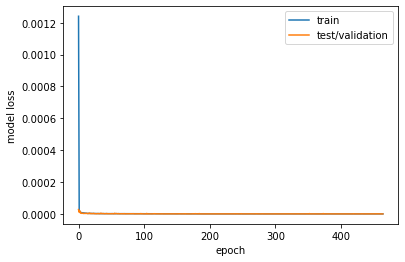

In [18]:
score = model4.evaluate(xy_valid, z_valid, batch_size=32, verbose=1)

# print performance
print()
print('Test loss:', score)
#print('Test accuracy:', score[1])

# look into training history

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test/validation'], loc='best')
plt.show()

Prediction time:  23.899839400008204


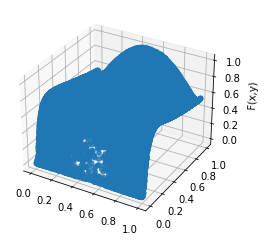

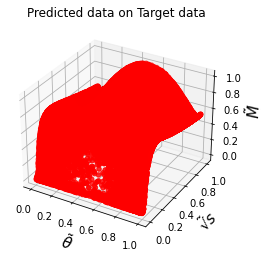

In [43]:
xy_valid, z_valid = prediction_NN(5000000,1000000, xy, M, scaler_out ,scaler_in)

start = timeit.default_timer()
z_predicted = model4.predict(xy_valid)
stop = timeit.default_timer()
prediction_time4 = stop - start

init = 0
end = 50000
print ("Prediction time: ", prediction_time4)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel('F(x,y)')
ax.scatter(xy_valid[init:end,0],xy_valid[init:end,1], z_valid[init:end])
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_title("Predicted data on Target data")
ax1.scatter(xy_valid[init:end,0], xy_valid[init:end,1], z_predicted[init:end],c='red')
ax1.set_xlabel('$\~ \u03B8 $', fontsize=15)
ax1.set_ylabel('$\~ \u221A s$', fontsize=15)
ax1.set_zlabel('$\~ M$', fontsize=15)
#plt.ylim(1000)
#ax.view_init(45,35)
plt.savefig('C:/Users/User/Desktop/gghhpredictedsecond.png')
plt.grid(True); plt.show()


### Annullamento scaling

In [44]:
xy_valid, z_predicted, z_valid = rescale(xy_valid, z_predicted, z_valid, scaler_in, scaler_out)


In [45]:
err_4 = relative_error(z_predicted, z_valid)

### Errori

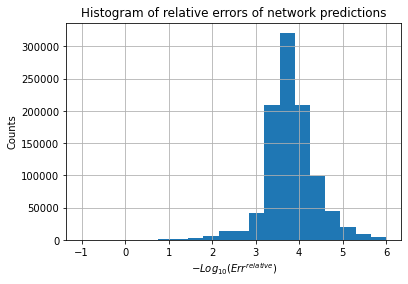

In [47]:
n_bins = 20
n, bins, patches = plt.hist(-np.log10(err_4), n_bins, range=(-1,6))

plt.xlabel('$- Log_{10}(Err^{relative})$')
plt.title('Histogram of relative errors of network predictions')
plt.grid(True)
plt.ylabel("Counts")
plt.savefig('C:/Users/User/Desktop/gghhhistosecond.png')
plt.show()

### Mappa degli errori

In [48]:
val_ang = (math.pi)/10
val_en = (3000 - 125.35*2)/10

In [49]:
err_map_4 = array_for_error_map (val_ang, val_en, 0, xy_valid, err_4, 'ang', 10)


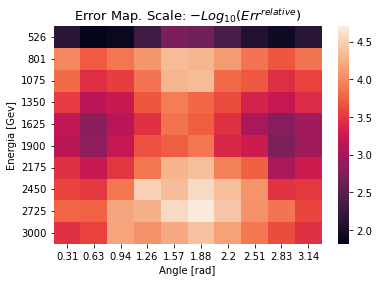

In [50]:
ang4 = []
En4 = []
for i in range(10):
    ang4.append(round((i+1)*val_ang,2))
    En4.append(round(125.35*2+(i+1)*val_en,))
    
ax = sns.heatmap(-np.log10(err_map_4),xticklabels = ang4, yticklabels = En4)
ax.set_title("Error Map. Scale: $- Log_{10}(Err^{relative})$", fontsize = 13)
ax.set_ylabel("Energia [Gev]")
ax.set_xlabel("Angle [rad]")
plt.savefig('C:/Users/User/Desktop/gghhmapsecond.png')
plt.show()

In [29]:
t_sum = 0
for i in range(len(t)):
    t_sum += t[i]
    
print ("Tempo per la generazione di", len(M),"elementi con MadGraph:",t_sum)
print ("Tempo di training della rete:", training_time4)
print ("Tempo di predizione della rete di",len(z_predicted),"elementi:", prediction_time4)


Tempo per la generazione di 9999776 elementi con MadGraph: 29845.920000000002
Tempo di training della rete: 10885.547172499999
Tempo di predizione della rete di 1000000 elementi: 23.986942499999714


In [30]:
t_1 = t_sum/len(M)
t_regression1 = t_1*len(z_predicted)
print("Interpolazione del tempo di generazione di",len(z_predicted),"elementi con MadGraph:",t_regression1)

Interpolazione del tempo di generazione di 1000000 elementi con MadGraph: 2984.6588563583823


In [33]:
n_min4 = round(training_time4/(t_sum/len(M)-prediction_time4/len(z_predicted)))

In [34]:
print("Numero minimo necessario per riassorbire il tempo di predizione della rete e renderlo un metodo conveniente:",n_min4)


Numero minimo necessario per riassorbire il tempo di predizione della rete e renderlo un metodo conveniente: 3676715


In [ ]:
m = 6000000/17907.55
